In [1]:
import os
import tensorflow as tf
import numpy as np
import matplotlib.pyplot as plt

In [2]:
!curl -L "https://app.roboflow.com/ds/T9nOGsPdnS?key=iNSAHdn1mM" > roboflow.zip; unzip roboflow.zip; rm roboflow.zip
%cd /content/
%mkdir images/
%mv train images/train
%mv valid images/valid

  % Total    % Received % Xferd  Average Speed   Time    Time     Time  Current
                                 Dload  Upload   Total   Spent    Left  Speed
100   889  100   889    0     0   1229      0 --:--:-- --:--:-- --:--:--  1227
100 11.0M  100 11.0M    0     0  4681k      0  0:00:02  0:00:02 --:--:-- 11.4M
Archive:  roboflow.zip
 extracting: README.roboflow.txt     
   creating: train/
   creating: train/imagery satellite with fire/
 extracting: train/imagery satellite with fire/100_jpg.rf.a3a550d42742b14118cea113c67246e6.jpg  
 extracting: train/imagery satellite with fire/100_jpg.rf.b7dd566e83a14cb44aa52373f939df07.jpg  
 extracting: train/imagery satellite with fire/100_jpg.rf.c8985e0ef36a8a9424d0742e4f1a881a.jpg  
 extracting: train/imagery satellite with fire/102_jpg.rf.ace98147e50af85161c77067640da6b8.jpg  
 extracting: train/imagery satellite with fire/102_jpg.rf.b75a591284bcc68fb1ed58c3dbbd59b6.jpg  
 extracting: train/imagery satellite with fire/102_jpg.rf.c942aa11ff5f

In [3]:
import tensorflow_datasets as tfds
builder = tfds.folder_dataset.ImageFolder('images/')
print(builder.info)
raw_train = builder.as_dataset(split='train', shuffle_files=True)
raw_valid = builder.as_dataset(split='valid', shuffle_files=True)

tfds.core.DatasetInfo(
    name='image_folder',
    version=1.0.0,
    description='Generic image classification dataset.',
    homepage='https://www.tensorflow.org/datasets/catalog/image_folder',
    features=FeaturesDict({
        'image': Image(shape=(None, None, 3), dtype=tf.uint8),
        'image/filename': Text(shape=(), dtype=tf.string),
        'label': ClassLabel(shape=(), dtype=tf.int64, num_classes=2),
    }),
    total_num_examples=2450,
    splits={
        'train': 2250,
        'valid': 200,
    },
    supervised_keys=('image', 'label'),
    citation="""""",
    redistribution_info=,
)



In [4]:
IMG_SIZE = 160 # All images will be resized to 160x160

def format_example(pair):
  image, label = pair['image'], pair['label']
  image = tf.cast(image, tf.float32)
  image = (image/127.5) - 1
  image = tf.image.resize(image, (IMG_SIZE, IMG_SIZE))
  return image, label

In [5]:
train = raw_train.map(format_example)
validation = raw_valid.map(format_example)


In [18]:
BATCH_SIZE = 16
SHUFFLE_BUFFER_SIZE = 500

In [19]:
train_batches = train.shuffle(SHUFFLE_BUFFER_SIZE).batch(BATCH_SIZE)
validation_batches = validation.batch(BATCH_SIZE)


In [20]:
for image_batch, label_batch in train_batches.take(1):
   pass

image_batch.shape

TensorShape([16, 160, 160, 3])

In [21]:
IMG_SHAPE = (IMG_SIZE, IMG_SIZE, 3)

# Create the base model from the pre-trained model MobileNet V2
base_model = tf.keras.applications.MobileNetV2(input_shape=IMG_SHAPE,
                                               include_top=False,
                                               weights='imagenet')

In [22]:
feature_batch = base_model(image_batch)
print(feature_batch.shape)

(16, 5, 5, 1280)


In [23]:
base_model.trainable = False

In [24]:
# Let's take a look at the base model architecture
base_model.summary()

Model: "mobilenetv2_1.00_160"
__________________________________________________________________________________________________
Layer (type)                    Output Shape         Param #     Connected to                     
input_2 (InputLayer)            [(None, 160, 160, 3) 0                                            
__________________________________________________________________________________________________
Conv1 (Conv2D)                  (None, 80, 80, 32)   864         input_2[0][0]                    
__________________________________________________________________________________________________
bn_Conv1 (BatchNormalization)   (None, 80, 80, 32)   128         Conv1[0][0]                      
__________________________________________________________________________________________________
Conv1_relu (ReLU)               (None, 80, 80, 32)   0           bn_Conv1[0][0]                   
_______________________________________________________________________________

In [25]:
global_average_layer = tf.keras.layers.GlobalAveragePooling2D()
feature_batch_average = global_average_layer(feature_batch)
print(feature_batch_average.shape)

(16, 1280)


In [26]:
prediction_layer = tf.keras.layers.Dense(1)
prediction_batch = prediction_layer(feature_batch_average)
print(prediction_batch.shape)

(16, 1)


In [27]:
model = tf.keras.Sequential([
  base_model,
  global_average_layer,
  prediction_layer
])

In [28]:
base_learning_rate = 0.0001
model.compile(optimizer=tf.keras.optimizers.RMSprop(learning_rate=base_learning_rate),
              loss=tf.keras.losses.BinaryCrossentropy(from_logits=True),
              metrics=['accuracy'])

In [29]:
model.summary()

Model: "sequential_1"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
mobilenetv2_1.00_160 (Functi (None, 5, 5, 1280)        2257984   
_________________________________________________________________
global_average_pooling2d_1 ( (None, 1280)              0         
_________________________________________________________________
dense_1 (Dense)              (None, 1)                 1281      
Total params: 2,259,265
Trainable params: 1,281
Non-trainable params: 2,257,984
_________________________________________________________________


In [30]:
len(model.trainable_variables)

2

In [31]:
initial_epochs = 20
validation_steps=20

loss0,accuracy0 = model.evaluate(validation_batches, steps = validation_steps)

13/20 [==================>...........] - ETA: 0s - loss: 0.9975 - accuracy: 0.5100WARNING:tensorflow:Your input ran out of data; interrupting training. Make sure that your dataset or generator can generate at least `steps_per_epoch * epochs` batches (in this case, 20 batches). You may need to use the repeat() function when building your dataset.


20/20 [==============================] - 3s 35ms/step - loss: 0.9975 - accuracy: 0.5100


In [32]:
print("initial loss: {:.2f}".format(loss0))
print("initial accuracy: {:.2f}".format(accuracy0))

initial loss: 1.00
initial accuracy: 0.51


In [33]:
history = model.fit(train_batches,
                    epochs=initial_epochs,
                    validation_data=validation_batches)

Epoch 1/20
141/141 [==============================] - 11s 49ms/step - loss: 0.5373 - accuracy: 0.6680 - val_loss: 0.3782 - val_accuracy: 0.8300
Epoch 2/20
141/141 [==============================] - 6s 41ms/step - loss: 0.3138 - accuracy: 0.8969 - val_loss: 0.2461 - val_accuracy: 0.9150
Epoch 3/20
141/141 [==============================] - 6s 41ms/step - loss: 0.2244 - accuracy: 0.9293 - val_loss: 0.1787 - val_accuracy: 0.9550
Epoch 4/20
141/141 [==============================] - 6s 41ms/step - loss: 0.1783 - accuracy: 0.9444 - val_loss: 0.1498 - val_accuracy: 0.9500
Epoch 5/20
141/141 [==============================] - 6s 41ms/step - loss: 0.1499 - accuracy: 0.9507 - val_loss: 0.1211 - val_accuracy: 0.9650
Epoch 6/20
141/141 [==============================] - 7s 43ms/step - loss: 0.1312 - accuracy: 0.9591 - val_loss: 0.1064 - val_accuracy: 0.9700
Epoch 7/20
141/141 [==============================] - 6s 42ms/step - loss: 0.1178 - accuracy: 0.9631 - val_loss: 0.0986 - val_accuracy: 0.970

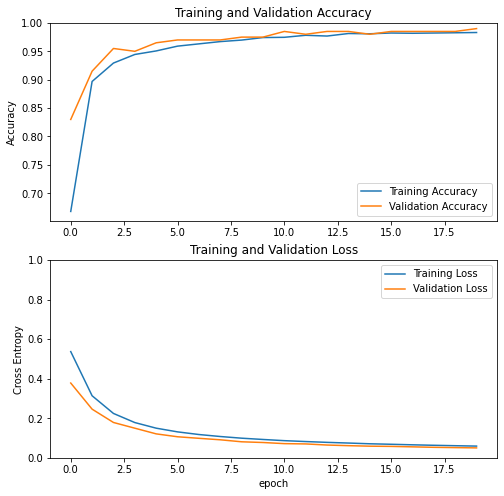

In [34]:
acc = history.history['accuracy']
val_acc = history.history['val_accuracy']

loss = history.history['loss']
val_loss = history.history['val_loss']

plt.figure(figsize=(8, 8))
plt.subplot(2, 1, 1)
plt.plot(acc, label='Training Accuracy')
plt.plot(val_acc, label='Validation Accuracy')
plt.legend(loc='lower right')
plt.ylabel('Accuracy')
plt.ylim([min(plt.ylim()),1])
plt.title('Training and Validation Accuracy')

plt.subplot(2, 1, 2)
plt.plot(loss, label='Training Loss')
plt.plot(val_loss, label='Validation Loss')
plt.legend(loc='upper right')
plt.ylabel('Cross Entropy')
plt.ylim([0,1.0])
plt.title('Training and Validation Loss')
plt.xlabel('epoch')
plt.show()

In [35]:
base_model.trainable = True

In [36]:
# Let's take a look to see how many layers are in the base model
print("Number of layers in the base model: ", len(base_model.layers))

# Fine-tune from this layer onwards
fine_tune_at = 100

# Freeze all the layers before the `fine_tune_at` layer
for layer in base_model.layers[:fine_tune_at]:
  layer.trainable =  False

Number of layers in the base model:  154


In [37]:
model.compile(loss=tf.keras.losses.BinaryCrossentropy(from_logits=True),
              optimizer = tf.keras.optimizers.RMSprop(learning_rate=base_learning_rate/10),
              metrics=['accuracy'])

In [38]:
model.summary()

Model: "sequential_1"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
mobilenetv2_1.00_160 (Functi (None, 5, 5, 1280)        2257984   
_________________________________________________________________
global_average_pooling2d_1 ( (None, 1280)              0         
_________________________________________________________________
dense_1 (Dense)              (None, 1)                 1281      
Total params: 2,259,265
Trainable params: 1,862,721
Non-trainable params: 396,544
_________________________________________________________________


In [39]:
len(model.trainable_variables)

56

In [40]:
fine_tune_epochs = 10
total_epochs =  initial_epochs + fine_tune_epochs

history_fine = model.fit(train_batches,
                         epochs=total_epochs,
                         initial_epoch =  history.epoch[-1],
                         validation_data=validation_batches)

Epoch 20/30
141/141 [==============================] - 16s 67ms/step - loss: 0.2069 - accuracy: 0.8920 - val_loss: 0.1072 - val_accuracy: 0.9600
Epoch 21/30
141/141 [==============================] - 9s 58ms/step - loss: 0.1019 - accuracy: 0.9560 - val_loss: 0.1751 - val_accuracy: 0.9400
Epoch 22/30
141/141 [==============================] - 9s 59ms/step - loss: 0.0656 - accuracy: 0.9782 - val_loss: 0.1796 - val_accuracy: 0.9450
Epoch 23/30
141/141 [==============================] - 9s 59ms/step - loss: 0.0499 - accuracy: 0.9858 - val_loss: 0.1818 - val_accuracy: 0.9500
Epoch 24/30
141/141 [==============================] - 9s 58ms/step - loss: 0.0333 - accuracy: 0.9911 - val_loss: 0.1505 - val_accuracy: 0.9550
Epoch 25/30
141/141 [==============================] - 9s 58ms/step - loss: 0.0376 - accuracy: 0.9893 - val_loss: 0.1277 - val_accuracy: 0.9600
Epoch 26/30
141/141 [==============================] - 9s 59ms/step - loss: 0.0217 - accuracy: 0.9951 - val_loss: 0.1188 - val_accuracy

In [41]:
acc += history_fine.history['accuracy']
val_acc += history_fine.history['val_accuracy']

loss += history_fine.history['loss']
val_loss += history_fine.history['val_loss']

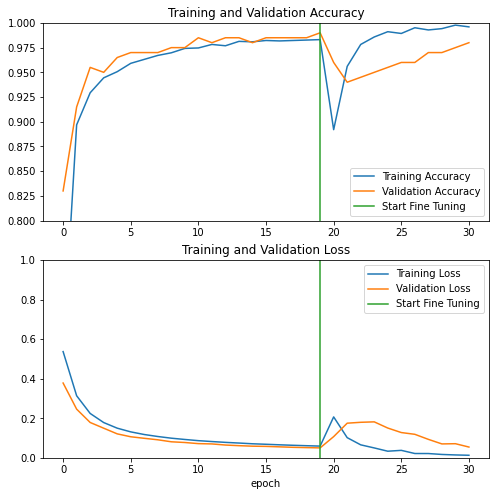

In [42]:
plt.figure(figsize=(8, 8))
plt.subplot(2, 1, 1)
plt.plot(acc, label='Training Accuracy')
plt.plot(val_acc, label='Validation Accuracy')
plt.ylim([0.8, 1])
plt.plot([initial_epochs-1,initial_epochs-1],
          plt.ylim(), label='Start Fine Tuning')
plt.legend(loc='lower right')
plt.title('Training and Validation Accuracy')

plt.subplot(2, 1, 2)
plt.plot(loss, label='Training Loss')
plt.plot(val_loss, label='Validation Loss')
plt.ylim([0, 1.0])
plt.plot([initial_epochs-1,initial_epochs-1],
         plt.ylim(), label='Start Fine Tuning')
plt.legend(loc='upper right')
plt.title('Training and Validation Loss')
plt.xlabel('epoch')
plt.show()

In [43]:
model.save("/content/mobilenet.h5")

/usr/local/lib/python3.7/dist-packages/tensorflow/python/keras/utils/generic_utils.py:497: CustomMaskWarning: Custom mask layers require a config and must override get_config. When loading, the custom mask layer must be passed to the custom_objects argument.
  category=CustomMaskWarning)
